In [560]:
from collections import defaultdict, namedtuple
import sys
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats

In [598]:
phase_dir = '../phased_spark_upd'
ped_file = '../data/spark.ped.quads.ped'
family_sizes = [4]
chrom = '22'
build = '38'

In [599]:
cyto = []
with open('../data/cytoBand%s.txt' % build, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0] == 'chr%s' % chrom:
            cyto.append((int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))

In [600]:
sample_to_affected = dict()
sample_to_sex = dict()

with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        sample_to_affected[pieces[1]] = pieces[5]
        sample_to_sex[pieces[1]] = pieces[4]

In [601]:
family_to_individuals = dict()

# pull families
for j in family_sizes:
	with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, 'X' if chrom=='PAR1' else chrom, j), 'r') as f:
		next(f) # skip header
		for line in f:
			pieces = line.strip().split('\t')
			family_key = pieces[0]
			individuals = pieces[1:(1+j)]

			family_to_individuals[family_key] = individuals
            

In [602]:
print(chrom)
# pull phase data for each family

family_to_states = defaultdict(list)
family_to_pos = defaultdict(list)
for family_size in family_sizes:
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, family_size), 'r')  as f:
        next(f) # skip header

        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            state = [int(x) for x in pieces[1:(6+2*family_size)]]
            start_pos, end_pos = [int(x) for x in pieces[(6+2*family_size):(8+2*family_size)]]
            assert end_pos >= start_pos

            family_to_states[family_key].append(state)
            family_to_pos[family_key].append((start_pos, end_pos))


22


In [603]:
Recombination = namedtuple('Recombination', ['family', 'chrom', 'start_pos', 'end_pos', 'length',
    'family_size', 'is_mat', 'is_pat', 'children'])

recombinations = []
for family_key, states in family_to_states.items():
    states = np.asarray(states)
    positions = np.asarray(family_to_pos[family_key])
    inds = family_to_individuals[family_key]
    m = len(inds)

    # ------------------ Recombinations ---------------------
    # for each child's phase
    for i in range(8, 4+2*m):

        is_mat = i%2==0
        is_pat = i%2==1

        in_recomb = False 
        start_pos = None
        for change_index in np.where((states[:-1, i] != states[1:, i]))[0]:
            if states[change_index, i] != -1 and states[change_index+1, i] != -1:
                start_pos, end_pos = positions[change_index, 1], positions[change_index+1, 0]
                assert start_pos <= end_pos
                recombinations.append(Recombination(family_key, chrom, 
                                                    start_pos, end_pos, end_pos-start_pos+1,
                                                    family_size, is_mat, is_pat, inds[2:]))
                in_recomb = False
            elif in_recomb:
                assert states[change_index, i] == -1
                assert start_pos is not None
                end_pos = positions[change_index+1, 0]
                assert start_pos <= end_pos
                recombinations.append(Recombination(family_key, chrom, 
                                                    start_pos, end_pos, end_pos-start_pos+1,
                                                    family_size, is_mat, is_pat, inds[2:]))
                in_recomb = False
                
            elif not in_recomb:
                assert states[change_index+1, i] == -1
                start_pos = positions[change_index, 1]
                in_recomb = True
                

In [604]:
N = 1000000
breakpoints = []
for c in cyto:
    breakpoints.extend(np.arange(c[0], c[1]-N, N).tolist())
breakpoints = np.array(breakpoints)

hotspot_starts = breakpoints[:-1]
hotspot_ends = breakpoints[1:]

# aff-aff/aff-typ/typ-typ, mat/pat
aff_hotspots = np.zeros((len(hotspot_starts), 3, 2))

# M-M/M-F/F-F
sex_hotspots = np.zeros((len(hotspot_starts), 3, 2))
print(hotspots.shape)

for i, (hotspot_start, hotspot_end) in enumerate(zip(hotspot_starts, hotspot_ends)):
    for recomb in recombinations:
        overlap = min(hotspot_end, recomb.end_pos) - max(hotspot_start, recomb.start_pos)
        assert overlap <= recomb.length
        if overlap > 0:
            num_affected = len([x for x in recomb.children if sample_to_affected[x]=='2'])
            num_F = len([x for x in recomb.children if sample_to_sex[x]=='2'])
            aff_hotspots[i, 2-num_affected, int(recomb.is_pat)] += overlap/recomb.length
            sex_hotspots[i, num_F, int(recomb.is_pat)] += overlap/recomb.length

num_aff_aff = len([v for v in family_to_individuals.values() if sample_to_affected[v[2]]=='2' and sample_to_affected[v[3]]=='2'])
num_aff_typ = len([v for v in family_to_individuals.values() if (sample_to_affected[v[2]]=='2' and sample_to_affected[v[3]]=='1') or (sample_to_affected[v[2]]=='1' and sample_to_affected[v[3]]=='2')])
num_typ_typ = len([v for v in family_to_individuals.values() if sample_to_affected[v[2]]=='1' and sample_to_affected[v[3]]=='1'])
print('aff-aff', num_aff_aff, 'aff-typ', num_aff_typ, 'typ-typ', num_typ_typ)

# normalization
aff_hotspots[:, 0, :] = aff_hotspots[:, 0, :]/(2*num_aff_aff)
aff_hotspots[:, 1, :] = aff_hotspots[:, 1, :]/(2*num_aff_typ)
aff_hotspots[:, 2, :] = aff_hotspots[:, 2, :]/(2*num_typ_typ)

num_F_F = len([v for v in family_to_individuals.values() if sample_to_sex[v[2]]=='2' and sample_to_sex[v[3]]=='2'])
num_M_F = len([v for v in family_to_individuals.values() if (sample_to_sex[v[2]]=='2' and sample_to_sex[v[3]]=='1') or (sample_to_affected[v[2]]=='1' and sample_to_affected[v[3]]=='2')])
num_M_M = len([v for v in family_to_individuals.values() if sample_to_sex[v[2]]=='1' and sample_to_sex[v[3]]=='1'])
print('M-M', num_M_M, 'M-F', num_M_F, 'F-F', num_F_F)

# normalization
sex_hotspots[:, 0, :] = sex_hotspots[:, 0, :]/(2*num_M_M)
sex_hotspots[:, 1, :] = sex_hotspots[:, 1, :]/(2*num_M_F)
sex_hotspots[:, 2, :] = sex_hotspots[:, 2, :]/(2*num_F_F)



(1600, 3, 3, 2)
aff-aff 706 aff-typ 3063 typ-typ 52
M-M 1692 M-F 1768 F-F 378


In [605]:
aff_pvalues = np.ones((aff_hotspots.shape[0], 3))
for i in range(aff_hotspots.shape[0]):
    aff_pvalues[i, 0] = scipy.stats.fisher_exact([[2*num_aff_aff*aff_hotspots[i, 0, 0], 2*num_aff_aff*(1-aff_hotspots[i, 0, 0])], 
                                              [2*num_aff_typ*aff_hotspots[i, 1, 0], 2*num_aff_typ*(1-aff_hotspots[i, 1, 0])]])[1]
    
    aff_pvalues[i, 1] = scipy.stats.fisher_exact([[2*num_aff_aff*aff_hotspots[i, 0, 1], 2*num_aff_aff*(1-aff_hotspots[i, 0, 1])], 
                                              [2*num_aff_typ*aff_hotspots[i, 1, 1], 2*num_aff_typ*(1-aff_hotspots[i, 1, 1])]])[1]
    
    aff_pvalues[i, 2] = scipy.stats.fisher_exact([[2*num_aff_aff*np.sum(aff_hotspots[i, 0, :]), 2*num_aff_aff*(1-np.sum(aff_hotspots[i, 0, :]))], 
                                              [2*num_aff_typ*np.sum(aff_hotspots[i, 1, :]), 2*num_aff_typ*(1-np.sum(aff_hotspots[i, 1, :]))]])[1]

sex_pvalues = np.ones((sex_hotspots.shape[0], 3))
for i in range(sex_hotspots.shape[0]):
    sex_pvalues[i, 0] = scipy.stats.fisher_exact([[2*num_M_M*sex_hotspots[i, 0, 0], 2*num_M_M*(1-sex_hotspots[i, 0, 0])], 
                                              [2*num_M_F*sex_hotspots[i, 1, 0], 2*num_M_F*(1-sex_hotspots[i, 1, 0])]])[1]
    
    sex_pvalues[i, 1] = scipy.stats.fisher_exact([[2*num_M_M*sex_hotspots[i, 0, 1], 2*num_M_M*(1-sex_hotspots[i, 0, 1])], 
                                              [2*num_M_F*sex_hotspots[i, 1, 1], 2*num_M_F*(1-sex_hotspots[i, 1, 1])]])[1]
    
    sex_pvalues[i, 2] = scipy.stats.fisher_exact([[2*num_M_M*np.sum(sex_hotspots[i, 0, :]), 2*num_M_M*(1-np.sum(sex_hotspots[i, 0, :]))], 
                                              [2*num_M_F*np.sum(sex_hotspots[i, 1, :]), 2*num_M_F*(1-np.sum(sex_hotspots[i, 1, :]))]])[1]
                                              

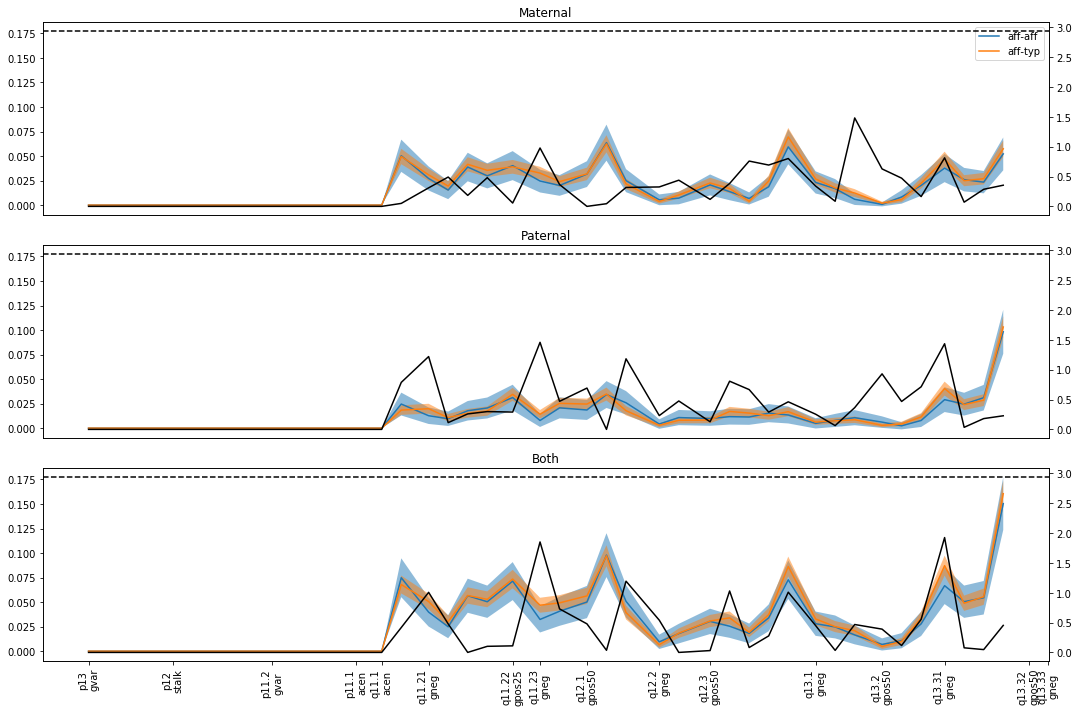

In [606]:
plt.figure(figsize=(15, 10))

def plot_with_conf(p, label, n):
    plt.plot(hotspot_starts, p, label=label)
    std = 2*np.sqrt(p*(1-p)/n)
    plt.fill_between(hotspot_starts, p-std, p+std, alpha=0.5)
    

ax1 = plt.subplot(3, 1, 1)
if num_aff_aff > 100:
    plot_with_conf(aff_hotspots[:, 0, 0], 'aff-aff', num_aff_aff)
if num_aff_typ > 100:
    plot_with_conf(aff_hotspots[:, 1, 0], 'aff-typ', num_aff_typ)
if num_typ_typ > 100:
    plot_with_conf(aff_hotspots[:, 2, 0], 'typ-typ', num_typ-typ)
    
plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Maternal')

alt_ax1 = ax1.twinx()
alt_ax1.plot(hotspot_starts, -np.log10(aff_pvalues[:, 0]), color='black')
alt_ax1.axhline(-np.log10(0.05/hotspot_starts.shape[0]), linestyle='--', color='black')

ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
if num_aff_aff > 100:
    plot_with_conf(aff_hotspots[:, 0, 1], 'aff-aff', num_aff_aff)
if num_aff_typ > 100:
    plot_with_conf(aff_hotspots[:, 1, 1], 'aff-typ', num_aff_typ)
if num_typ_typ > 100:
    plot_with_conf(aff_hotspots[:, 2, 1], 'typ-typ', num_typ-typ)
    
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Paternal')

alt_ax2 = ax2.twinx()
alt_ax2.plot(hotspot_starts, -np.log10(aff_pvalues[:, 1]), color='black')
alt_ax2.axhline(-np.log10(0.05/hotspot_starts.shape[0]), linestyle='--', color='black')


ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
if num_aff_aff > 100:
    plot_with_conf(np.sum(aff_hotspots[:, 0, :], axis=1), 'aff-aff', num_aff_aff)
if num_aff_typ > 100:
    plot_with_conf(np.sum(aff_hotspots[:, 1, :], axis=1), 'aff-typ', num_aff_typ)
if num_typ_typ > 100:
    plot_with_conf(np.sum(aff_hotspots[:, 2, :], axis=1), 'typ-typ', num_typ-typ)

plt.xticks([c[0] for c in cyto], [c[2]+'\n'+c[3] for c in cyto], rotation=90)
plt.title('Both')

alt_ax3 = ax3.twinx()
alt_ax3.plot(hotspot_starts, -np.log10(aff_pvalues[:, 2]), color='black')
alt_ax3.axhline(-np.log10(0.05/hotspot_starts.shape[0]), linestyle='--', color='black')

plt.tight_layout()
plt.show()

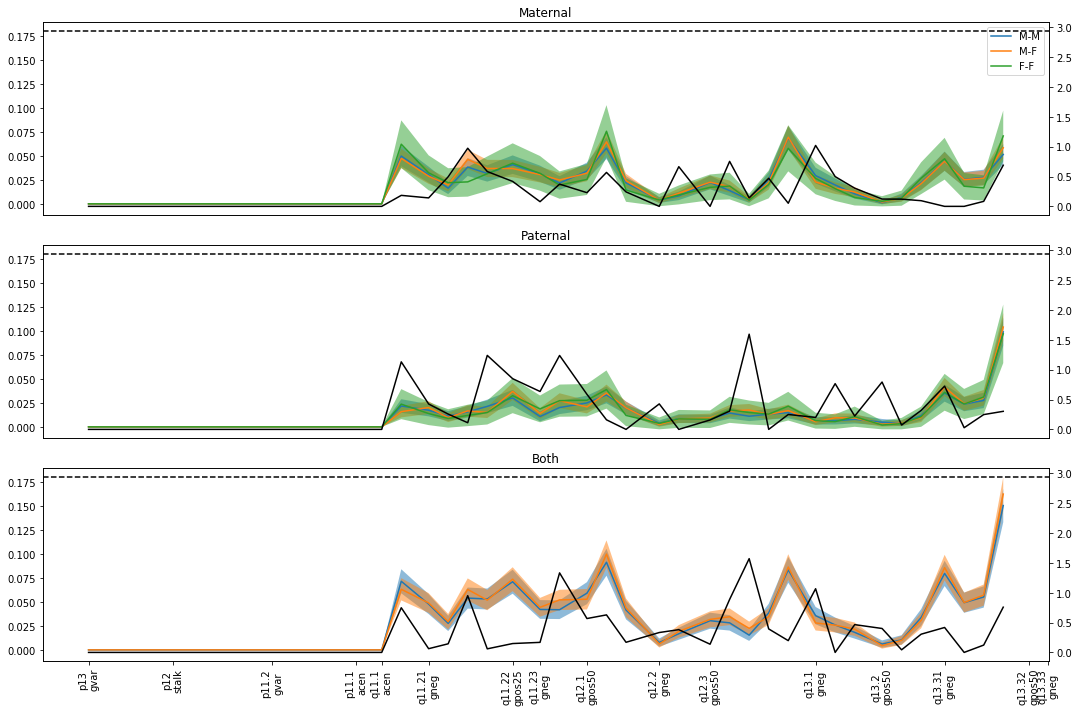

In [607]:
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
if num_M_M > 100:
    plot_with_conf(sex_hotspots[:, 0, 0], 'M-M', num_M_M)
if num_M_F > 100:
    plot_with_conf(sex_hotspots[:, 1, 0], 'M-F', num_M_F)
if num_F_F > 100:
    plot_with_conf(sex_hotspots[:, 2, 0], 'F-F', num_F_F)
    
plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Maternal')

alt_ax1 = ax1.twinx()
alt_ax1.plot(hotspot_starts, -np.log10(sex_pvalues[:, 0]), color='black')
alt_ax1.axhline(-np.log10(0.05/hotspot_starts.shape[0]), linestyle='--', color='black')

ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
if num_M_M > 100:
    plot_with_conf(sex_hotspots[:, 0, 1], 'M-M', num_M_M)
if num_M_F > 100:
    plot_with_conf(sex_hotspots[:, 1, 1], 'M-F', num_M_F)
if num_F_F > 100:
    plot_with_conf(sex_hotspots[:, 2, 1], 'F-F', num_F_F)
    
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Paternal')

alt_ax2 = ax2.twinx()
alt_ax2.plot(hotspot_starts, -np.log10(sex_pvalues[:, 1]), color='black')
alt_ax2.axhline(-np.log10(0.05/hotspot_starts.shape[0]), linestyle='--', color='black')


ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
if num_aff_aff > 100:
    plot_with_conf(np.sum(sex_hotspots[:, 0, :], axis=1), 'M_M', num_M_M)
if num_aff_typ > 100:
    plot_with_conf(np.sum(sex_hotspots[:, 1, :], axis=1), 'M_F', num_M_F)
if num_typ_typ > 100:
    plot_with_conf(np.sum(sex_hotspots[:, 2, :], axis=1), 'F_F', num_F_F)

plt.xticks([c[0] for c in cyto], [c[2]+'\n'+c[3] for c in cyto], rotation=90)
plt.title('Both')

alt_ax3 = ax3.twinx()
alt_ax3.plot(hotspot_starts, -np.log10(sex_pvalues[:, 2]), color='black')
alt_ax3.axhline(-np.log10(0.05/hotspot_starts.shape[0]), linestyle='--', color='black')

plt.tight_layout()
plt.show()